In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import time
import torch.optim as optim
import pandas as pd
import copy
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
import functools
import json
from torch_geometric.data import Data
import enum

import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph
from utils.graph_utils import compute_stats_batch,normalize_data,normalize,unnormalize
from models.MGN import MeshGraphNet
from models.GUnet import GUNet



In [2]:
#load graphs one by one
file_path = '../data_graphs/vel_3h_survived'
#get file names sorted in order
graph_files = [i for i in os.listdir(file_path) if "list" not in i and "pt" in i]
graph_files = sorted(graph_files,key=lambda x:int(x.split("_")[-1].split(".")[0]) if x.split("_")[-1].split(".")[0].isdigit() else 0)[:]
graph_list = []
for file in tqdm(graph_files):
    with open(os.path.join(file_path,file),'rb') as f:
            graph_list.append(torch.load(f))
            
graph_list[0], len(graph_list)

100%|██████████| 275/275 [00:06<00:00, 44.78it/s]


(Data(x=[63267, 9], edge_index=[2, 371642], edge_attr=[371642, 3], y=[63267, 2], cells=[122499, 3], mesh_pos=[63267, 2], files=[3]),
 275)

In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 8,
         'batch_size': 8,
         'hidden_dim': 10,
         'epochs': 50,
         'opt': 'adam',
         'opt_scheduler': 'cos',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.001,
         'train_size': 40,
         'test_size': 2,
         'device':'cpu',
         'shuffle': True,
         'save_velo_val': False,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [4]:
!ls ../best_models/best_models2 | grep 2h

vel_2h_survived_f_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20.csv
vel_2h_survived_f_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20.pt
vel_2h_survived_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20.csv
vel_2h_survived_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20.pt
vel_2h_survived_meshgraphnet_mse_plateau_nl8_bs8_hd10_ep80_wd1e-05_lr0.00062_shuff_True_tr250_te20.csv
vel_2h_survived_meshgraphnet_mse_plateau_nl8_bs8_hd10_ep80_wd1e-05_lr0.00062_shuff_True_tr250_te20.pt


In [6]:
# load model.
stats_list = compute_stats_batch(graph_list)
dataset = graph_list[-50:]

model_name = "vel_3h_survived_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20"
args.device = torch.device('cpu') # 
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 2 # the dynamic variables have the shape of 2 (velocity)
PATH = f"../best_models/best_models2/{model_name}.pt"#os.path.join( checkpoint_dir, f'{model_name}.pt')

if args.model_type == 'meshgraphnet':
        model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args)
if args.model_type == 'gunet':
    model = GUNet(num_node_features, num_classes)

model.load_state_dict(torch.load(PATH, map_location=args.device))
normalized = True

In [7]:
del graph_list

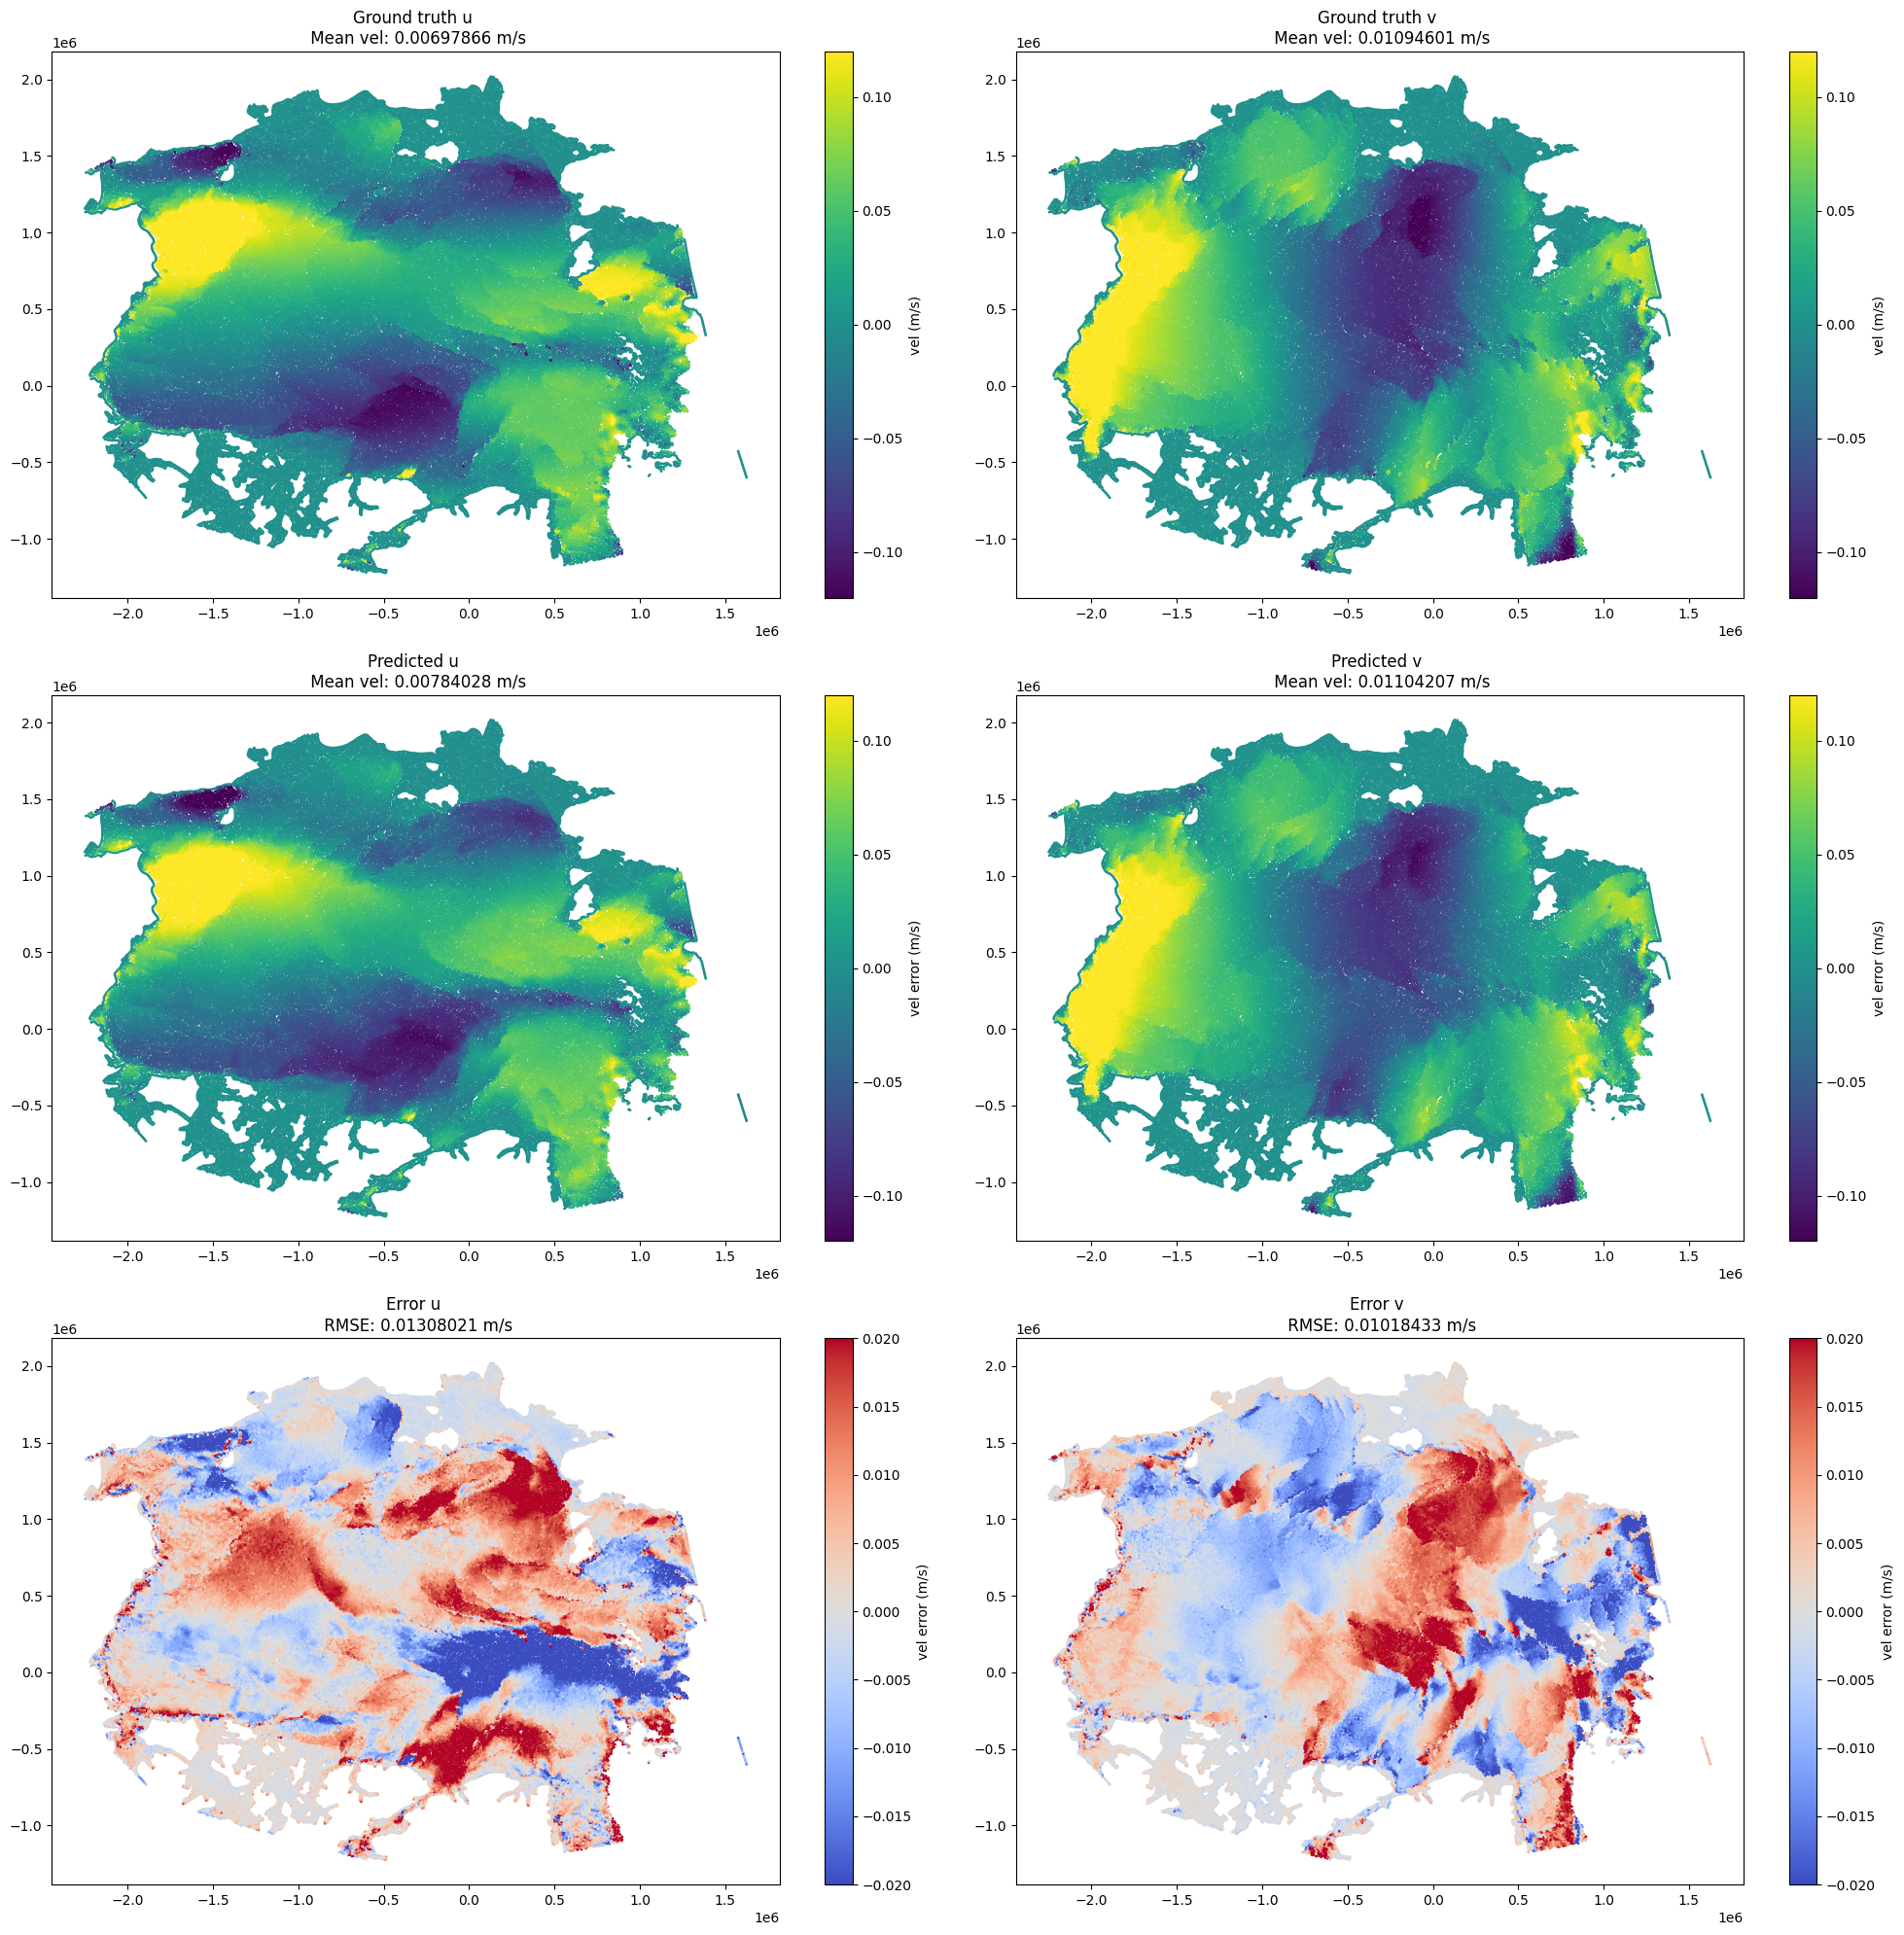

In [14]:
#both components
dataset_viz = copy.deepcopy(dataset[10:])
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
dt = 3600*3

for i,graph in enumerate(dataset_viz):
    mask = graph.x[:, -1] == 0
    if normalized:
        data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
    else:
        data = graph
    pred = model(data)
    if normalized:
        pred = unnormalize(pred,mean_vec_y,std_vec_y).detach().numpy()[mask]
        target = unnormalize(data.y,mean_vec_y,std_vec_y)[mask].numpy()
        data.x = unnormalize(data.x,mean_vec_x,std_vec_x)
    else:
        pred = pred.detach().numpy()[mask]
        target = data.y[mask].detach().numpy()

    ground_v = target
    predicted_v = pred

    error_v = predicted_v-ground_v

    #compute angle error
    v_norm = np.linalg.norm(target,axis=1)
    v_norm_pred = np.linalg.norm(pred,axis=1)
    cos_theta = np.sum(target*pred,axis=1)/(v_norm*v_norm_pred+1e-18)
    theta = np.arccos(np.clip(cos_theta,-0.999,0.999))
    theta = np.degrees(theta)
    

    #compute position error
    positions_t0 = data.mesh_pos[mask]
    pos_t1 = positions_t0 + dt*target
    pos_pred = positions_t0 + dt*pred

    error_pos = np.linalg.norm(pos_pred - pos_t1, axis=1)
    
    
    rmse_v = np.sqrt(np.mean(error_v**2,axis=0))
    rmse_pos = np.sqrt(np.mean(error_pos**2))

    fig, axs = plt.subplots(3,2,figsize=(20,20))
    vel_vmax = np.mean(ground_v) + 2*np.std(ground_v)

    axs = axs.flatten()
    im1 = axs[0].scatter(positions_t0[:,0],positions_t0[:,1],c=ground_v[:,0],s=1,vmin=-vel_vmax,vmax=vel_vmax)
    axs[0].set_title(f'Ground truth u \n Mean vel: {np.mean(ground_v[:,0]):.8f} m/s')
    plt.colorbar(im1,label='vel (m/s)')

    im2 = axs[1].scatter(positions_t0[:,0],positions_t0[:,1],c=ground_v[:,1],s=1,vmin=-vel_vmax,vmax=vel_vmax)
    axs[1].set_title(f'Ground truth v \n Mean vel: {np.mean(ground_v[:,1]):.8f} m/s')
    plt.colorbar(im2,label='vel (m/s)')

    im3 = axs[2].scatter(positions_t0[:,0],positions_t0[:,1],c=predicted_v[:,0],s=1,vmin=-vel_vmax,vmax=vel_vmax)
    axs[2].set_title(f'Predicted u \n Mean vel: {np.mean(predicted_v[:,0]):.8f} m/s')
    plt.colorbar(im3,label='vel error (m/s)')

    im3 = axs[3].scatter(positions_t0[:,0],positions_t0[:,1],c=predicted_v[:,1],s=1,vmin=-vel_vmax,vmax=vel_vmax)
    axs[3].set_title(f'Predicted v \n Mean vel: {np.mean(predicted_v[:,1]):.8f} m/s')
    plt.colorbar(im3,label='vel error (m/s)')

    im4 = axs[4].scatter(positions_t0[:,0],positions_t0[:,1],c=error_v[:,0],s=1,vmin=-0.02,vmax=0.02,cmap='coolwarm')
    axs[4].set_title(f'Error u \n RMSE: {rmse_v[0]:.8f} m/s')
    plt.colorbar(im4,label='vel error (m/s)')

    im5 = axs[5].scatter(positions_t0[:,0],positions_t0[:,1],c=error_v[:,1],s=1,vmin=-0.02,vmax=0.02,cmap='coolwarm')
    axs[5].set_title(f'Error v \n RMSE: {rmse_v[1]:.8f} m/s')
    plt.colorbar(im5,label='vel error (m/s)')


    plt.tight_layout()
    break
    plt.savefig(f'../figures/rmse_vel/mgn_mse_1h{i}.png')
    plt.close()

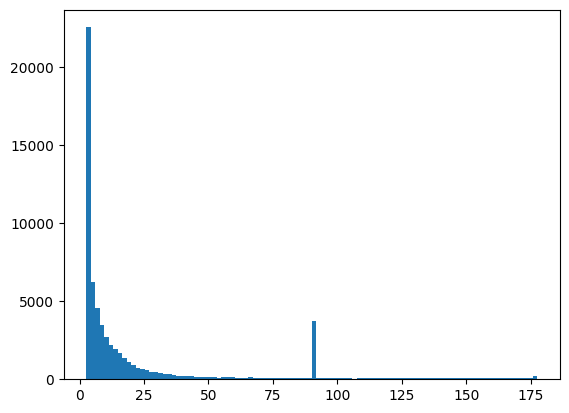

In [17]:
plt.hist(theta,bins=100)
pass

Text(0.5, 1.0, 'Angle error \n Mean angle error: 23.04467201 deg')

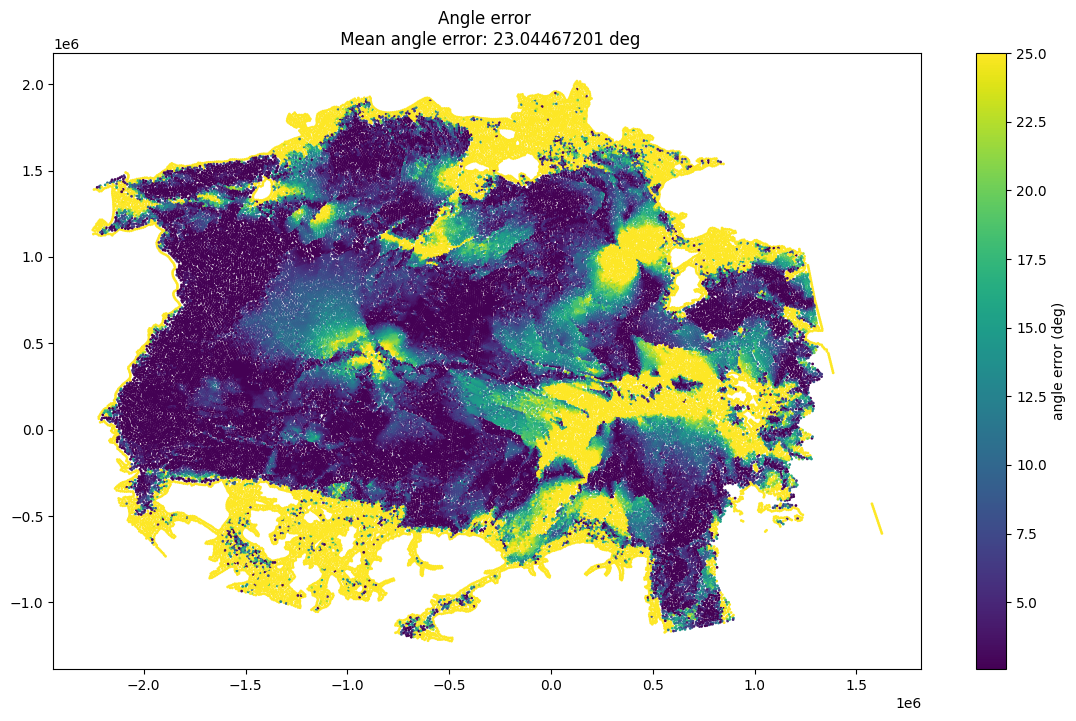

In [15]:
#angle error
plt.figure(figsize=(14,8))
plt.scatter(positions_t0[:,0],positions_t0[:,1],c=theta,s=1,vmax=25)
plt.colorbar(label='angle error (deg)')
plt.title(f'Angle error \n Mean angle error: {np.mean(theta):.8f} deg')

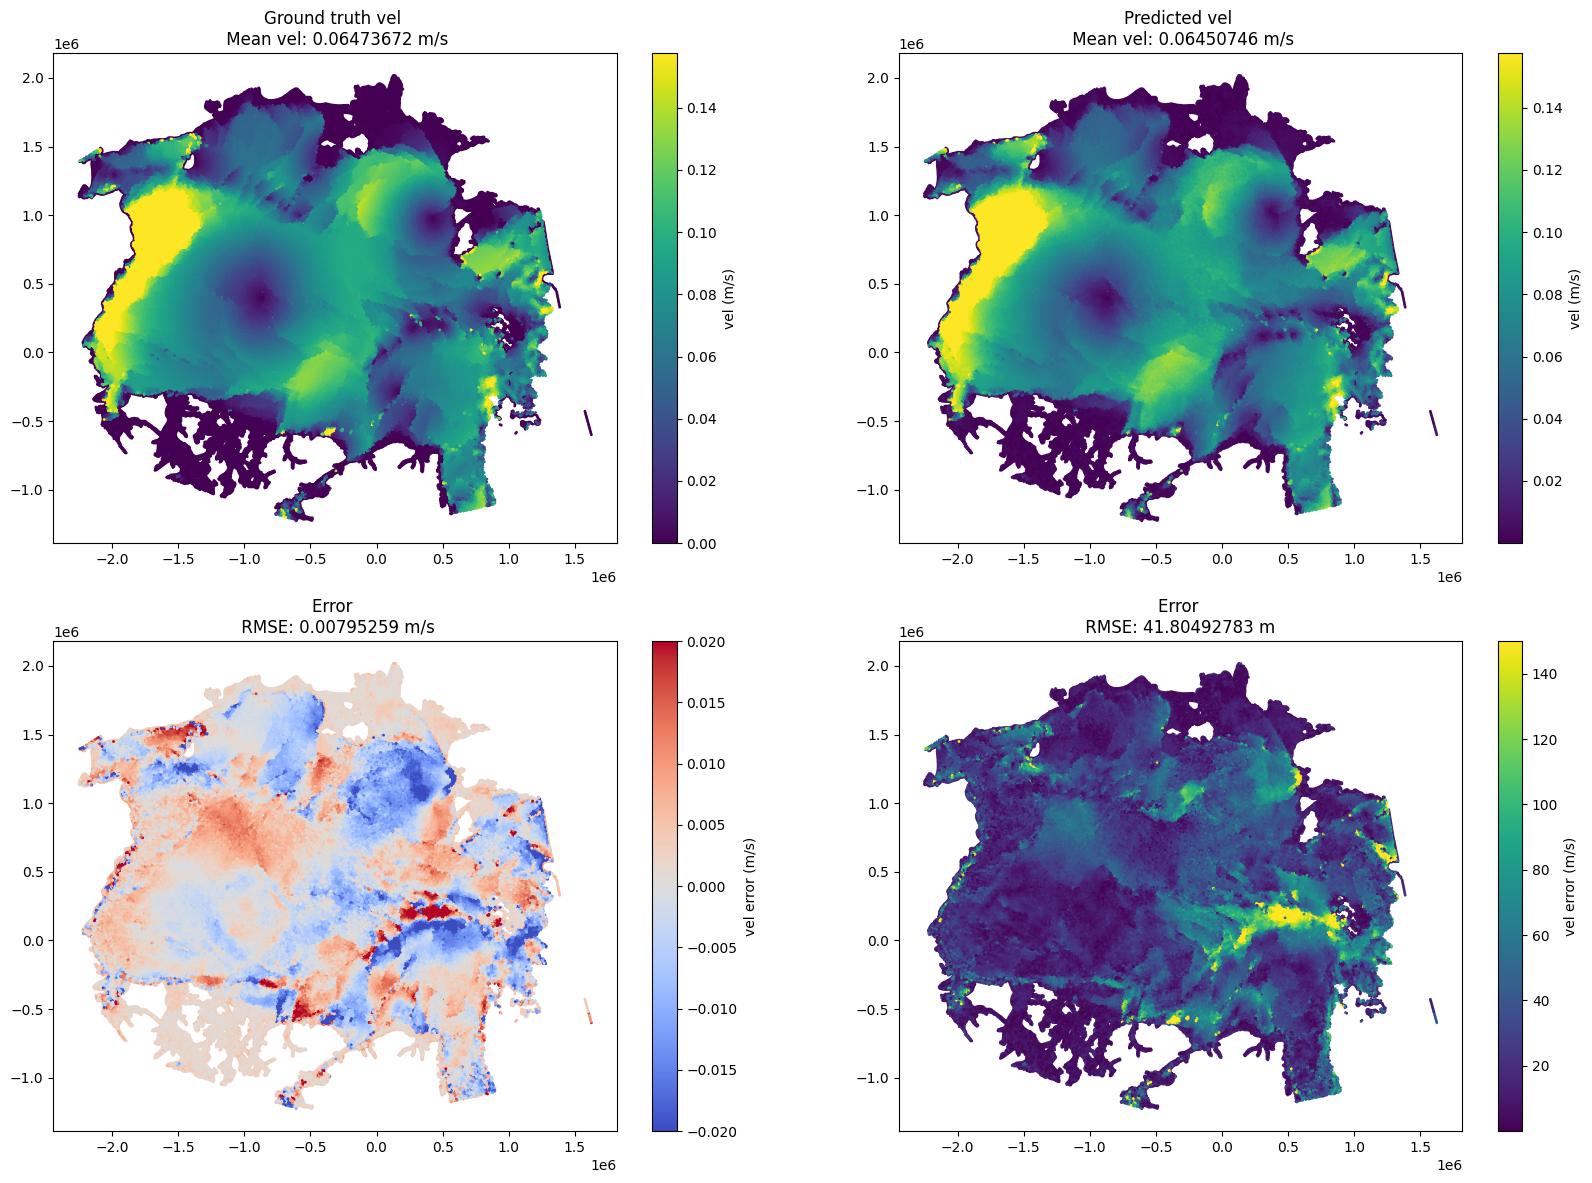

In [8]:
dataset_viz = copy.deepcopy(dataset[10:])
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
dt = 3600

for i,graph in enumerate(dataset_viz):
    mask = graph.x[:, -1] == 0
    if normalized:
        data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
    else:
        data = graph
    pred = model(data)
    if normalized:
        pred = unnormalize(pred,mean_vec_y,std_vec_y).detach().numpy()[mask]
        target = unnormalize(data.y,mean_vec_y,std_vec_y)[mask]
        data.x = unnormalize(data.x,mean_vec_x,std_vec_x)
    else:
        pred = pred.detach().numpy()[mask]
        target = data.y[mask].detach().numpy()

    ground_v = np.linalg.norm(target, axis=1)
    predicted_v = np.linalg.norm((pred), axis=1)

    error_v = predicted_v-ground_v
    
    positions_t0 = data.mesh_pos[mask]
    pos_t1 = positions_t0 + dt*target
    pos_pred = positions_t0 + dt*pred

    error_pos = np.linalg.norm(pos_pred - pos_t1, axis=1)
    
    
    rmse_v = np.sqrt(np.mean(error_v**2))
    rmse_pos = np.sqrt(np.mean(error_pos**2))

    fig, axs = plt.subplots(2,2,figsize=(20,14))
    vel_vmax = np.mean(ground_v) + 2*np.std(ground_v)

    axs = axs.flatten()
    im1 = axs[0].scatter(positions_t0[:,0],positions_t0[:,1],c=ground_v,s=1,vmax=vel_vmax)
    axs[0].set_title(f'Ground truth vel \n Mean vel: {np.mean(ground_v):.8f} m/s')
    plt.colorbar(im1,label='vel (m/s)')

    im2 = axs[1].scatter(positions_t0[:,0],positions_t0[:,1],c=predicted_v,s=1,vmax=vel_vmax)
    axs[1].set_title(f'Predicted vel \n Mean vel: {np.mean(predicted_v):.8f} m/s')
    plt.colorbar(im2,label='vel (m/s)')

    im3 = axs[2].scatter(positions_t0[:,0],positions_t0[:,1],c=error_v,s=1,vmin=-0.02,vmax=0.02,cmap='coolwarm')
    axs[2].set_title(f'Error \n RMSE: {rmse_v:.8f} m/s')
    plt.colorbar(im3,label='vel error (m/s)')

    im3 = axs[3].scatter(positions_t0[:,0],positions_t0[:,1],c=error_pos,s=1,vmax=150)
    axs[3].set_title(f'Error \n RMSE: {rmse_pos:.8f} m ')
    plt.colorbar(im3,label='vel error (m/s)')
    break
    plt.savefig(f'../figures/rmse_vel/mgn_mse_1h{i}.png')
    plt.close()

In [8]:
dataset_viz = copy.deepcopy(dataset)[-50:]
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list

#vel errors
rmse_inputs_true = []
rmse_inputs_pred = []
rmse_v_pred = []

#position errors
rmse_position = []
positions_t0 = []
positions_t1 = []
positions_pred = []

#angle errors
angle_errors = []

kn_pred = []
kn_input = []
kn_true = []

predictions = []
targets  = []
inputs = []
dt=3600

for i,graph in tqdm(enumerate(dataset_viz)):

    mask = graph.x[:, -1] == 0
    if normalized:
        data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
    else:
        data = graph
    pred = model(data)

    if normalized:
        pred = unnormalize(pred,mean_vec_y,std_vec_y).detach().numpy()[mask]
        target = unnormalize(data.y,mean_vec_y,std_vec_y)[mask].numpy()
        data.x = unnormalize(data.x,mean_vec_x,std_vec_x)
    else:
        pred = pred.detach().numpy()[mask]
        target = data.y[mask].detach().numpy()
        
    ground_v = np.linalg.norm(target, axis=1)
    predicted_v = np.linalg.norm((pred), axis=1)
    input_vel = np.linalg.norm(data.x[:,:2], axis=1)[mask]

    error_v = predicted_v-ground_v
    
    
    #velocity error
    rmse_v = np.sqrt(np.mean(error_v**2))
    error_in_pred = input_vel - predicted_v
    error_in_true = input_vel - ground_v

    rmse_in_pred = np.sqrt(np.mean(error_in_pred**2))
    rmse_in_true = np.sqrt(np.mean(error_in_true**2))
    

    #position error
    pos_t0 = data.mesh_pos[mask]
    pos_t1 = pos_t0 + dt*target
    pos_pred = pos_t0 + dt*pred
    error_pos = np.linalg.norm(pos_pred - pos_t1, axis=1)
    rmse_pos = np.sqrt(np.mean(error_pos**2))

    #angle error
    v_norm = np.linalg.norm(target,axis=1)
    v_norm_pred = np.linalg.norm(pred,axis=1)
    cos_theta = np.sum(target*pred,axis=1)/(v_norm*v_norm_pred + 1e-18)
    theta = np.arccos(np.clip(cos_theta,-1,1))
    theta = np.degrees(theta)


    rmse_inputs_true.append(rmse_in_true)
    rmse_inputs_pred.append(rmse_in_pred)
    rmse_v_pred.append(rmse_v)

    rmse_position.append(rmse_pos)
    positions_t0.append(pos_t0)
    positions_t1.append(pos_t1)
    positions_pred.append(pos_pred)

    angle_errors.append(np.nanmean(theta))

    kn_pred.append((predicted_v).mean())
    kn_input.append((input_vel).mean())
    kn_true.append((ground_v).mean())

    predictions.append(pred)
    targets.append(target)
    inputs.append(data.x[:,:2])

50it [00:25,  1.99it/s]


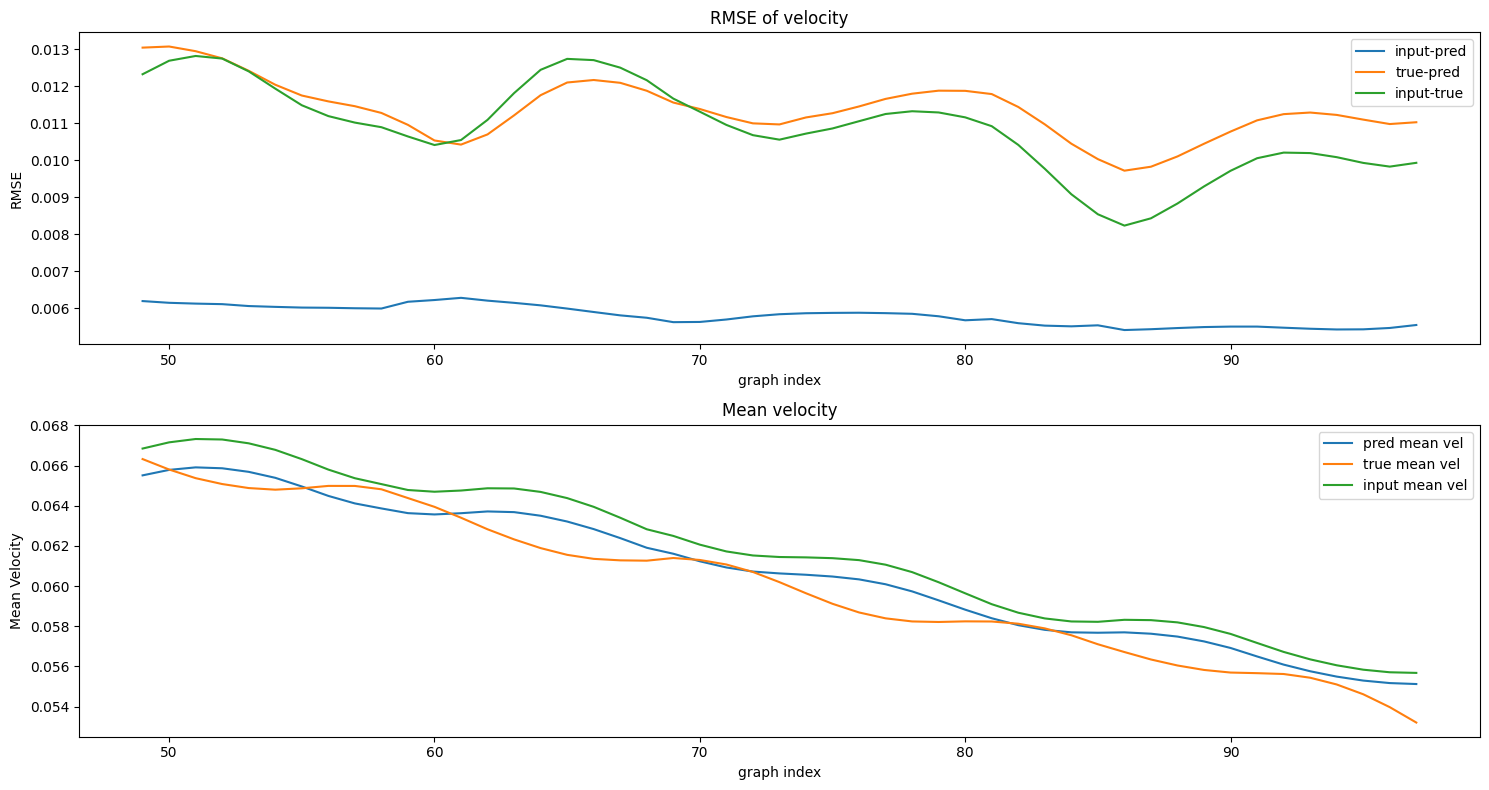

In [12]:
fig,axs = plt.subplots(2,1,figsize=(15,8))

x = np.arange(49,len(rmse_v_pred)+48)
axs[0].plot(x,rmse_inputs_pred[1:], label = "input-pred")
axs[0].plot(x,rmse_v_pred[1:], label = "true-pred")
axs[0].plot(x,rmse_inputs_true[1:], label = "input-true")
axs[0].set_xlabel("graph index")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE of velocity")
#axs[0].set_ylim(0,0.02)
axs[0].legend()


axs[1].plot(x,kn_pred[1:], label = "pred mean vel")
axs[1].plot(x,kn_true[1:], label = "true mean vel")
axs[1].plot(x,kn_input[1:], label = "input mean vel")
axs[1].set_xlabel("graph index")
axs[1].set_ylabel("Mean Velocity")
axs[1].set_title("Mean velocity")
axs[1].legend()
#axs[1].set_ylim(0,0.02)


plt.tight_layout()


In [10]:
all_targets = np.concatenate(targets,axis=0)
all_predictions = np.concatenate(predictions,axis=0)

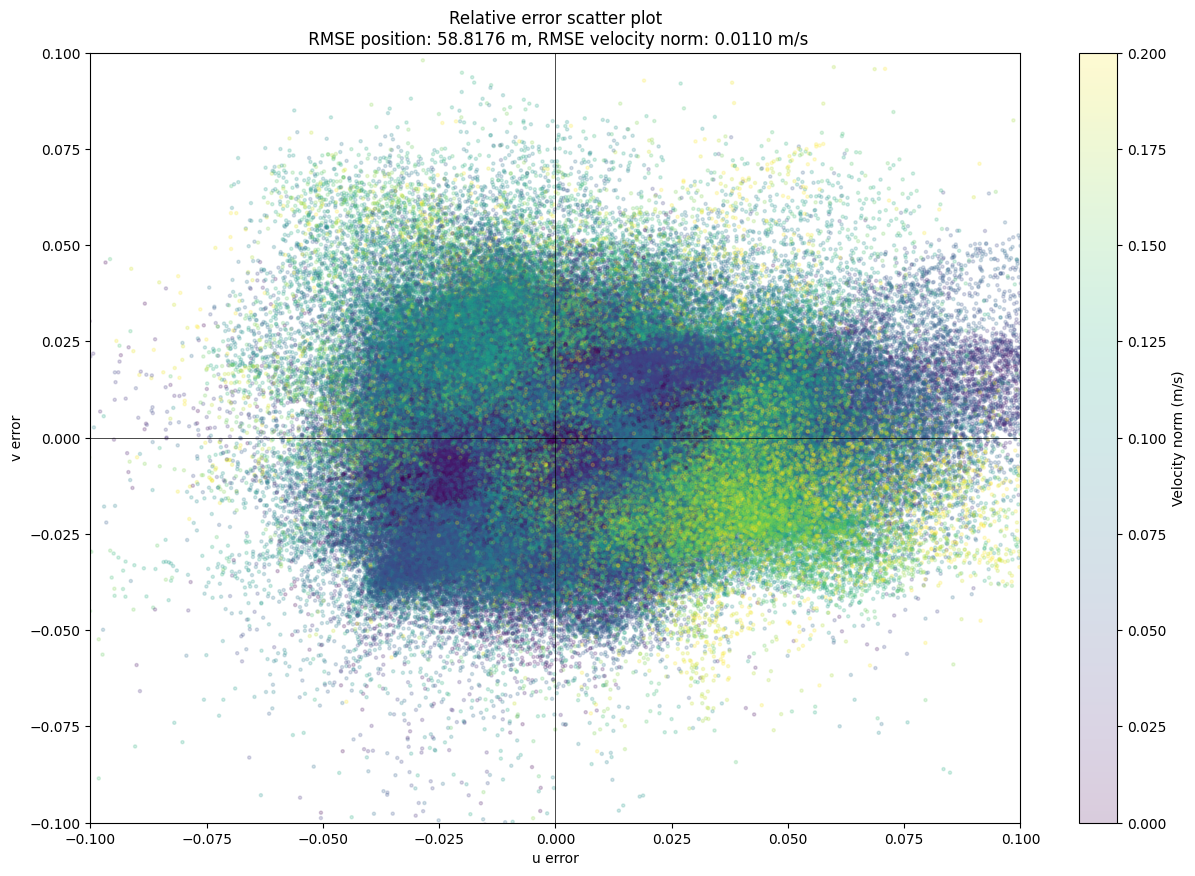

In [11]:
position_absolute_mean = float(np.mean(rmse_position))
velocity_absolute_mean = float(np.mean(rmse_v))

#get relative errors
u_error = (all_targets[:,0] - all_predictions[:,0]) #relative error
v_error = (all_targets[:,1] - all_predictions[:,1])

#compute target velocitity norm
target_vel_norm = np.linalg.norm(all_targets, axis=1)

#plot error scatter
plt.figure(figsize=(15,10))
plt.scatter(u_error,v_error, c=target_vel_norm,alpha=.2,cmap='viridis',s=5,vmax=0.2)
#center at 00 
plt.axhline(0, color='black',linewidth=.5)
plt.axvline(0, color='black',linewidth=.5)
zoom = 0.1
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
plt.colorbar(label='Velocity norm (m/s)')
plt.xlabel('u error')
plt.ylabel('v error')
plt.title(f'Relative error scatter plot\n RMSE position: {position_absolute_mean:.4f} m, RMSE velocity norm: {velocity_absolute_mean:.4f} m/s')
plt.show()

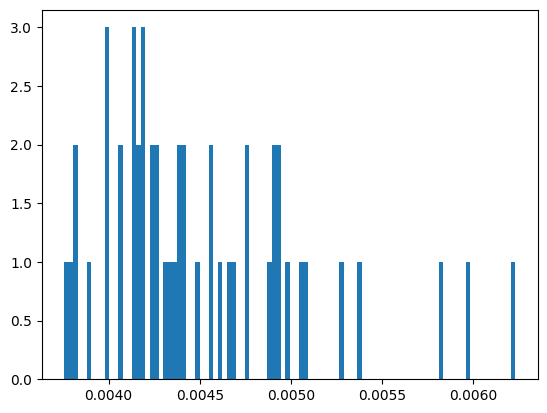

In [21]:
plt.hist(rmse_v_pred,bins=100)
pass

(63748, 2)
(63748, 2)


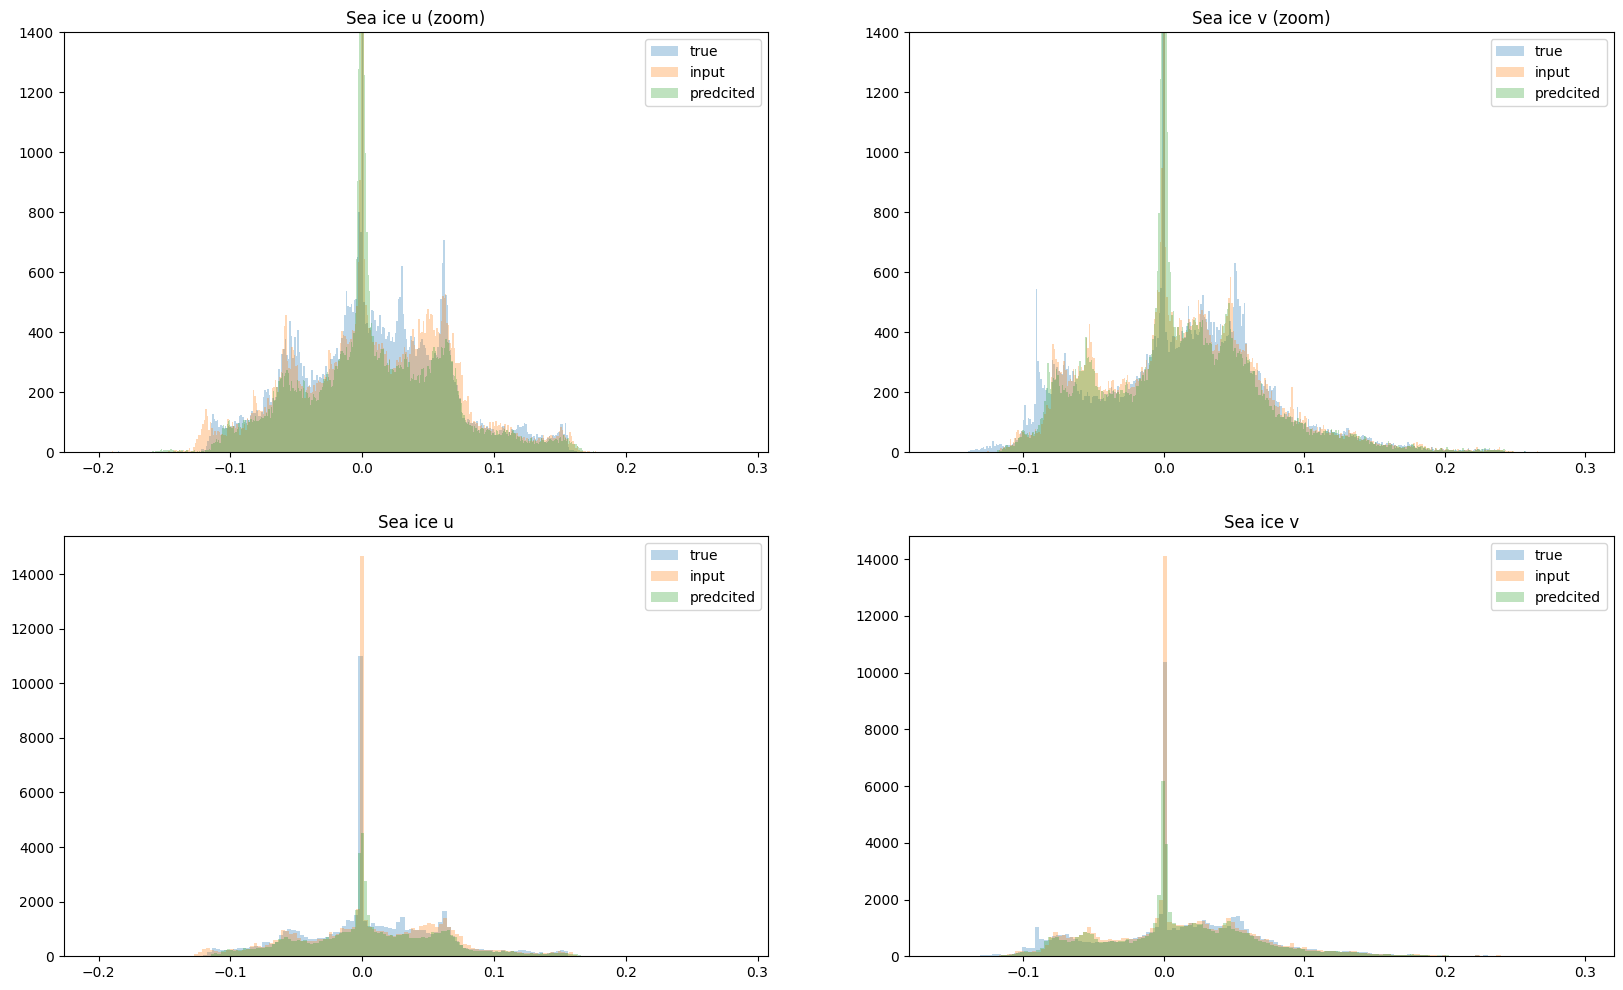

In [13]:
all_targets = targets[10]
all_predictions = predictions[10]
all_inputs = inputs[10]

print(all_targets.shape)
print(all_predictions.shape)
fig,axs = plt.subplots(2,2,figsize=(20,12))

axs[0,0].hist(all_targets[:,0],bins=400,alpha = 0.3, label = "true")
axs[0,0].hist(all_inputs[:,0],bins=400,alpha=0.3, label="input")
axs[0,0].hist(all_predictions[:,0],bins=400,alpha=0.3, label="predcited")


axs[0,0].set_ylim(0,1400)
axs[0,0].set_title("Sea ice u (zoom)")
axs[0,0].legend()


axs[0,1].hist(all_targets[:,1],bins=400,alpha = 0.3, label = "true")
axs[0,1].hist(all_inputs[:,1],bins=400,alpha=0.3, label="input")
axs[0,1].hist(all_predictions[:,1],bins=400,alpha=0.3, label="predcited")


axs[0,1].set_ylim(0,1400)
axs[0,1].set_title("Sea ice v (zoom)")
axs[0,1].legend()



axs[1,0].hist(all_targets[:,0],bins=150,alpha = 0.3, label = "true")
axs[1,0].hist(all_inputs[:,0],bins=150,alpha=0.3, label="input")
axs[1,0].hist(all_predictions[:,0],bins=150,alpha=0.3, label="predcited")


axs[1,0].set_title("Sea ice u")
axs[1,0].legend()


axs[1,1].hist(all_targets[:,1],bins=150,alpha = 0.3, label = "true")
axs[1,1].hist(all_inputs[:,1],bins=150,alpha=0.3, label="input")
axs[1,1].hist(all_predictions[:,1],bins=150,alpha=0.3, label="predcited")


axs[1,1].set_title("Sea ice v")
axs[1,1].legend()


In [15]:
from matplotlib.tri import Triangulation

def jacobian(x0, y0, x1, y1, x2, y2):
    return (x1-x0)*(y2-y0)-(x2-x0)*(y1-y0)

In [16]:
x0,y0 = pos_t0[:,0],pos_t0[:,1]
x1,y1 = pos_t1[:,0],pos_t1[:,1]
x_pred,y_pred = pos_pred[:,0],pos_pred[:,1]

# create subsampled mesh for matching nodes only
t0 = Triangulation(x0, y0).triangles
# find starting / ending coordinates for each elements
x0a, x0b, x0c = x0[t0].T
y0a, y0b, y0c = y0[t0].T
x1a, x1b, x1c = x1[t0].T
y1a, y1b, y1c = y1[t0].T
xpa, xpb, xpc = x_pred[t0].T
ypa, ypb, ypc = y_pred[t0].T

# compute area at the first and second snapshots (subsampled mesh)
a0 = jacobian(x0a, y0a, x0b, y0b, x0c, y0c)
a1 = jacobian(x1a, y1a, x1b, y1b, x1c, y1c)
ap = jacobian(xpa, ypa, xpb, ypb, xpc, ypc)

#divergence
div_true = (a0/a1)
div_pred = (a0/ap)

error = div_pred-div_true

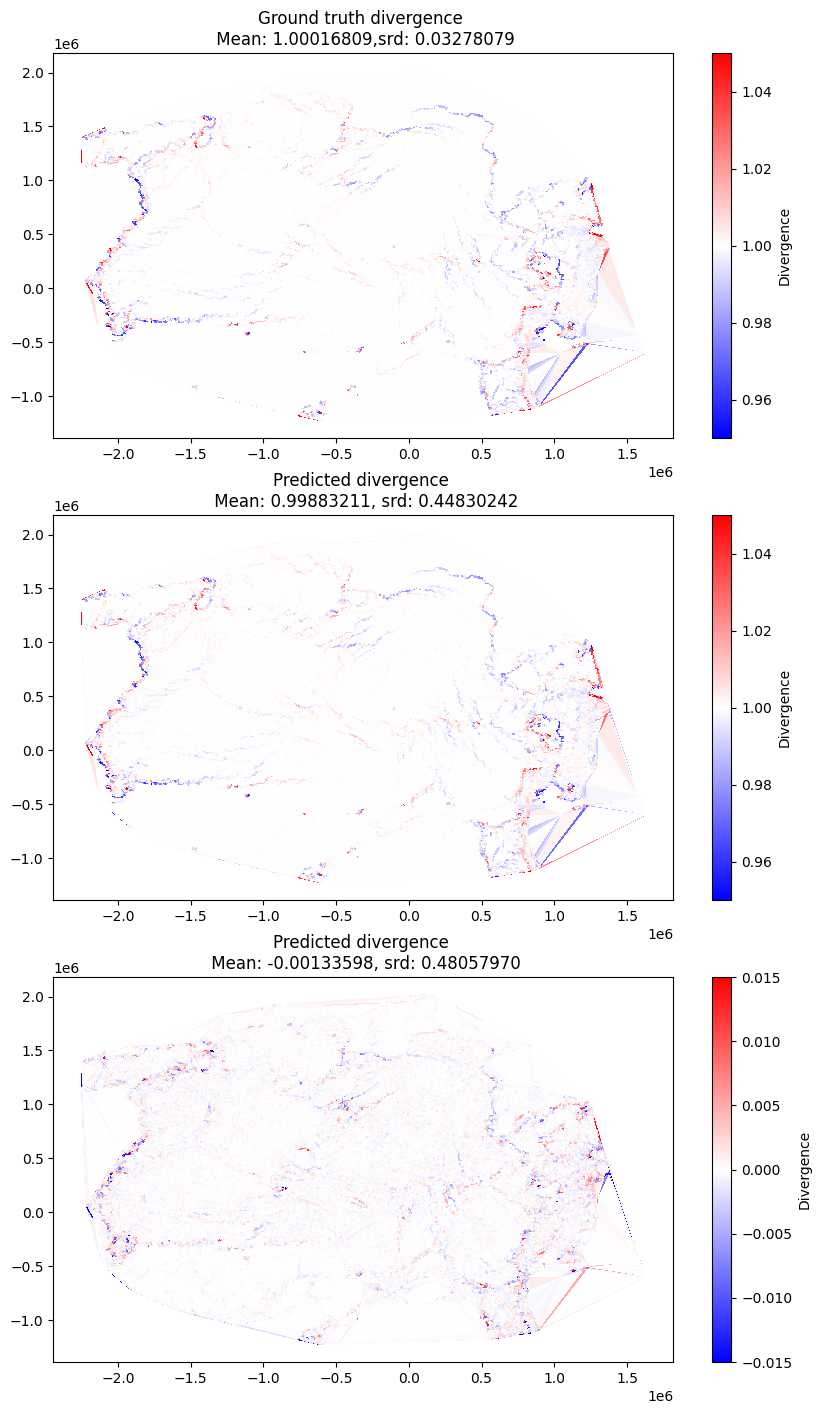

In [17]:
fig, axs = plt.subplots(3,1,figsize=(10,17))

axs = axs.flatten()
im1 = axs[0].tripcolor(x0, y0, div_true, triangles=t0, vmin=0.95, vmax=1.05, cmap='bwr')
axs[0].set_title(f'Ground truth divergence \n Mean: {torch.mean(div_true):.8f},srd: {torch.std(div_true):.8f}')
plt.colorbar(im1,label="Divergence")

im2 = axs[1].tripcolor(x0, y0, div_pred, triangles=t0, vmin=0.95, vmax=1.05, cmap='bwr')
axs[1].set_title(f'Predicted divergence \n Mean: {torch.mean(div_pred):.8f}, srd: {torch.std(div_pred):.8f}')
plt.colorbar(im2,label='Divergence')

im2 = axs[2].tripcolor(x0, y0, error, triangles=t0, cmap='bwr',vmin=-0.015,vmax=0.015)
axs[2].set_title(f'Predicted divergence \n Mean: {torch.mean(error):.8f}, srd: {torch.std(error):.8f}')
plt.colorbar(im2,label='Divergence')